In [1]:
import os
import time
import datetime
import json
import gc
from numba import jit

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn import metrics

from itertools import product

import altair as alt
from IPython.display import HTML

In [2]:
folder_path = 'data/'
train_identity = pd.read_csv(f'{folder_path}train_identity.csv')
train_transaction = pd.read_csv(f'{folder_path}train_transaction.csv')
test_identity = pd.read_csv(f'{folder_path}test_identity.csv')
test_transaction = pd.read_csv(f'{folder_path}test_transaction.csv')
sub = pd.read_csv(f'{folder_path}sample_submission.csv')
# let's combine the data and work with the whole dataset
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

In [5]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [6]:
train.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object', length=434)

## EDA

In [7]:
train.shape

(590540, 434)

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(4), object(31)
memory usage: 1.9+ GB


In [12]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
TransactionID,590540.0,3.282270e+06,1.704744e+05,2987000.000,3134634.750,3282269.500,3429904.25,3.577539e+06
isFraud,590540.0,3.499001e-02,1.837546e-01,0.000,0.000,0.000,0.00,1.000000e+00
TransactionDT,590540.0,7.372311e+06,4.617224e+06,86400.000,3027057.750,7306527.500,11246620.00,1.581113e+07
TransactionAmt,590540.0,1.350272e+02,2.391625e+02,0.251,43.321,68.769,125.00,3.193739e+04
card1,590540.0,9.898735e+03,4.901170e+03,1000.000,6019.000,9678.000,14184.00,1.839600e+04
card2,581607.0,3.625555e+02,1.577932e+02,100.000,214.000,361.000,512.00,6.000000e+02
card3,588975.0,1.531949e+02,1.133644e+01,100.000,150.000,150.000,150.00,2.310000e+02
card5,586281.0,1.992789e+02,4.124445e+01,100.000,166.000,226.000,226.00,2.370000e+02
addr1,524834.0,2.907338e+02,1.017411e+02,100.000,204.000,299.000,330.00,5.400000e+02
addr2,524834.0,8.680063e+01,2.690623e+00,10.000,87.000,87.000,87.00,1.020000e+02


In [14]:
train.isnull().sum()/len(train.index)

TransactionID     0.000000
isFraud           0.000000
TransactionDT     0.000000
TransactionAmt    0.000000
ProductCD         0.000000
card1             0.000000
card2             0.015127
card3             0.002650
card4             0.002670
card5             0.007212
card6             0.002660
addr1             0.111264
addr2             0.111264
dist1             0.596524
dist2             0.936284
P_emaildomain     0.159949
R_emaildomain     0.767516
C1                0.000000
C2                0.000000
C3                0.000000
C4                0.000000
C5                0.000000
C6                0.000000
C7                0.000000
C8                0.000000
C9                0.000000
C10               0.000000
C11               0.000000
C12               0.000000
C13               0.000000
                    ...   
id_11             0.761273
id_12             0.755761
id_13             0.784401
id_14             0.864456
id_15             0.761261
id_16             0.780980
i

In [15]:
one_value_cols = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]
one_value_cols == one_value_cols_test

False

In [16]:
one_value_cols

[]

In [17]:
one_value_cols_test

['V107']

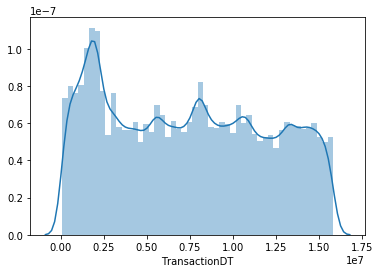

In [11]:
sns.distplot(train.TransactionDT)

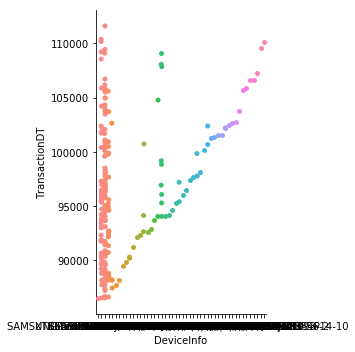

In [14]:
sns.catplot(x = "DeviceInfo", y = "TransactionDT", data=train.loc[1:1000])

In [ ]:
sns.catplot(x="day", y="total_bill", data=tips);

In [ ]:
# Generate some sequential data
x = np.array(list("ABCDEFGHIJ"))
y1 = np.arange(1, 11)
sns.barplot(x=x, y=y1, palette="rocket", ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("Sequential")
